## Configuration

#### Import Python Modules

In [1]:
import collections
import datetime
from google.cloud import storage
from io import BytesIO, StringIO
from operator import itemgetter
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
from PIL import Image
import random
import requests
import tempfile
from tensorflow.keras.preprocessing.image import load_img
import time
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tqdm

#### Tensorflow / Keras Modules

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D, GaussianNoise, SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

#### Import Project Modules

In [3]:
from src import config_data_processing as cdp
from src import image_manipulation as imm
from src import misc_functions as mf
from src import modeling as m

2020-09-30 14:33:57: Folder path C:/keras_model_save/ already exists
2020-09-30 14:33:57: Folder path C:/keras_epoch_results/ already exists


## Data Processing

#### Cropped 'Chest of drawers' Images

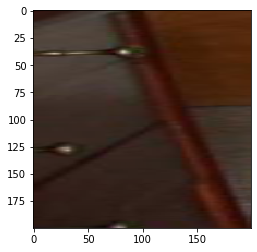

In [4]:
get_class1 = 'Chest of drawers'
x1 = mf.read_gcs_numpy_array(bucket_name = cdp.config_source_bucket_name, file_name = f'processed_files/{get_class1}/train_images_cropped.npy')
plt.imshow(x1[0])

#### Cropped 'Fireplace' Images

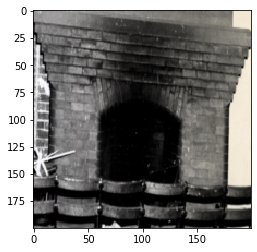

In [5]:
get_class2 = 'Fireplace'
x2 = mf.read_gcs_numpy_array(bucket_name = cdp.config_source_bucket_name, file_name = f'processed_files/{get_class2}/train_images_cropped.npy')
plt.imshow(x2[0])

#### Cropped 'Sofa bed' Images

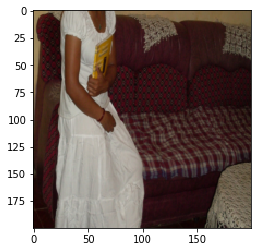

In [6]:
get_class3 = 'Sofa bed'
x3 = mf.read_gcs_numpy_array(bucket_name = cdp.config_source_bucket_name, file_name = f'processed_files/{get_class3}/train_images_cropped.npy')
plt.imshow(x3[0])

#### Create and Combine Binary Variables

In [7]:
binary1 = np.array([[1, 0, 0]] * x1.shape[0])
binary2 = np.array([[0, 1, 0]] * x2.shape[0])
binary3 = np.array([[0, 0, 1]] * x3.shape[0])
y = np.vstack([binary1, binary2, binary3])
x = np.vstack([x1, x2, x3])

#### Delete Objects from Memory

In [8]:
del x1; del x2; del x3; del binary1; del binary2; del binary3;

#### Split X and Y into 70/30 Train/Test

In [9]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, shuffle = True, random_state = 100)

#### Split Test Set into 15/15 Test/Validation

In [10]:
valid_x, test_x, valid_y, test_y = train_test_split(test_x, test_y, test_size = 0.5, shuffle = True, random_state = 100)

#### Class Weights

In [11]:
class_weight_dict = imm.make_class_weight_dict([np.argmax(x) for x in train_y], return_dict = True)

## Model Configuration

#### Parameters

In [12]:
mc_batch_size = 20
mc_epochs = 30
mc_learning_rate = 0.001
mc_dropout = 0.2

#### Calculate Training Steps

In [13]:
tsteps = int(train_x.shape[0]) // mc_batch_size
vsteps = int(valid_x.shape[0]) // mc_batch_size

## Model Architecture

#### Clear Session (this removes any trained model from your PC's memory)

In [14]:
train_start_time = time.time()
keras.backend.clear_session()

#### Define Shape of Input (width, height, channels)

In [15]:
x_input = Input((200, 200, 3))

#### Define Model Layers

In [16]:
# Convolutional Layer 1
# 3 x 3 filters are popular for reasons explained here:
#       https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
x = ZeroPadding2D(padding = (3, 3))(x_input)
x = Conv2D(50, (6, 6), strides = (1, 1), padding = 'valid', use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Convolutional Layer 2
x = Conv2D(50, (3, 3), strides = (2, 2), use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Convolutional Layer 3
x = Conv2D(50, (3, 3), strides = (2, 2), use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Convolutional Layer 4
x = Conv2D(50, (3, 3), strides = (2, 2), use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Convolutional Layer 5
x = Conv2D(150, (3, 3), strides = (2, 2), use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Convolutional Layer 6
x = Conv2D(150, (3, 3), strides = (2, 2), use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Convolutional Layer 7
x = Conv2D(150, (3, 3), strides = (2, 2), use_bias = False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (2,2), strides = (2, 2))(x)

# Dense Layers (output size 3 equal to number of classes)
x = Flatten()(x)
x = Dense(200)(x)
x = Dropout(mc_dropout)(x)
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dense(3, activation = 'softmax')(x)

model = Model(inputs = x_input, outputs = x, name = 'cnn_from_scratch') 
model.summary()

Model: "cnn_from_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 206, 206, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 201, 201, 50)      5400      
_________________________________________________________________
batch_normalization (BatchNo (None, 201, 201, 50)      200       
_________________________________________________________________
activation (Activation)      (None, 201, 201, 50)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 50)      22500     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 50) 

## Model Fitting

#### Keras Model Checkpoints (used for early stopping & logging epoch accuracy)

In [17]:
check_point = keras.callbacks.ModelCheckpoint(m.config_model_save_name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',  patience = m.config_max_worse_epochs)
csv_logger = keras.callbacks.CSVLogger(m.config_csv_save_name)

#### Define Model Compilation & Fit

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate = mc_learning_rate),
              metrics = ['categorical_accuracy'])

model.fit(train_x, train_y,
          epochs = mc_epochs,
          validation_data = (valid_x, valid_y),
          steps_per_epoch = tsteps,
          validation_steps = vsteps,
          callbacks = [check_point, early_stop, csv_logger],
          class_weight = class_weight_dict)

train_end_time = time.time()
m.sec_to_time_elapsed(train_end_time, train_start_time)

Epoch 1/30
115/115 [==============================] - ETA: 0s - loss: 1.7747 - categorical_accuracy: 0.38 - ETA: 1:06 - loss: 1.6163 - categorical_accuracy: 0.38 - ETA: 1:27 - loss: 1.6164 - categorical_accuracy: 0.38 - ETA: 1:36 - loss: 1.7286 - categorical_accuracy: 0.39 - ETA: 1:42 - loss: 1.6237 - categorical_accuracy: 0.42 - ETA: 1:45 - loss: 1.6264 - categorical_accuracy: 0.45 - ETA: 1:47 - loss: 1.5980 - categorical_accuracy: 0.46 - ETA: 1:48 - loss: 1.5356 - categorical_accuracy: 0.44 - ETA: 1:49 - loss: 1.5663 - categorical_accuracy: 0.44 - ETA: 1:49 - loss: 1.5729 - categorical_accuracy: 0.44 - ETA: 1:49 - loss: 1.5311 - categorical_accuracy: 0.45 - ETA: 1:48 - loss: 1.4980 - categorical_accuracy: 0.46 - ETA: 1:48 - loss: 1.4860 - categorical_accuracy: 0.45 - ETA: 1:47 - loss: 1.4737 - categorical_accuracy: 0.45 - ETA: 1:47 - loss: 1.4648 - categorical_accuracy: 0.45 - ETA: 1:46 - loss: 1.4765 - categorical_accuracy: 0.44 - ETA: 1:46 - loss: 1.4701 - categorical_accuracy: 0.4

115/115 [==============================] - ETA: 0s - loss: 1.1627 - categorical_accuracy: 0.66 - ETA: 1:06 - loss: 1.2831 - categorical_accuracy: 0.54 - ETA: 1:27 - loss: 1.3957 - categorical_accuracy: 0.57 - ETA: 1:37 - loss: 1.3112 - categorical_accuracy: 0.57 - ETA: 1:41 - loss: 1.2204 - categorical_accuracy: 0.60 - ETA: 1:45 - loss: 1.2109 - categorical_accuracy: 0.57 - ETA: 1:47 - loss: 1.1967 - categorical_accuracy: 0.57 - ETA: 1:48 - loss: 1.1614 - categorical_accuracy: 0.59 - ETA: 1:49 - loss: 1.1549 - categorical_accuracy: 0.58 - ETA: 1:49 - loss: 1.1239 - categorical_accuracy: 0.59 - ETA: 1:49 - loss: 1.1346 - categorical_accuracy: 0.58 - ETA: 1:49 - loss: 1.1092 - categorical_accuracy: 0.60 - ETA: 1:48 - loss: 1.0947 - categorical_accuracy: 0.61 - ETA: 1:48 - loss: 1.0786 - categorical_accuracy: 0.60 - ETA: 1:47 - loss: 1.0748 - categorical_accuracy: 0.60 - ETA: 1:46 - loss: 1.0550 - categorical_accuracy: 0.61 - ETA: 1:46 - loss: 1.0381 - categorical_accuracy: 0.61 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 1.1260 - categorical_accuracy: 0.52 - ETA: 1:05 - loss: 1.1046 - categorical_accuracy: 0.64 - ETA: 1:26 - loss: 1.1102 - categorical_accuracy: 0.61 - ETA: 1:36 - loss: 1.1025 - categorical_accuracy: 0.61 - ETA: 1:41 - loss: 1.0451 - categorical_accuracy: 0.61 - ETA: 1:44 - loss: 0.9812 - categorical_accuracy: 0.64 - ETA: 1:46 - loss: 0.9999 - categorical_accuracy: 0.64 - ETA: 1:47 - loss: 1.0510 - categorical_accuracy: 0.62 - ETA: 1:47 - loss: 1.0463 - categorical_accuracy: 0.61 - ETA: 1:47 - loss: 1.0285 - categorical_accuracy: 0.63 - ETA: 1:47 - loss: 1.0143 - categorical_accuracy: 0.64 - ETA: 1:48 - loss: 1.0197 - categorical_accuracy: 0.64 - ETA: 1:47 - loss: 1.0135 - categorical_accuracy: 0.63 - ETA: 1:47 - loss: 0.9860 - categorical_accuracy: 0.64 - ETA: 1:46 - loss: 0.9642 - categorical_accuracy: 0.65 - ETA: 1:45 - loss: 0.9864 - categorical_accuracy: 0.64 - ETA: 1:44 - loss: 1.0014 - categorical_accuracy: 0.63 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.9888 - categorical_accuracy: 0.47 - ETA: 1:06 - loss: 0.7997 - categorical_accuracy: 0.59 - ETA: 1:30 - loss: 0.8449 - categorical_accuracy: 0.63 - ETA: 1:39 - loss: 0.8088 - categorical_accuracy: 0.65 - ETA: 1:43 - loss: 0.8813 - categorical_accuracy: 0.62 - ETA: 1:46 - loss: 0.8176 - categorical_accuracy: 0.66 - ETA: 1:48 - loss: 0.8221 - categorical_accuracy: 0.65 - ETA: 1:48 - loss: 0.8324 - categorical_accuracy: 0.66 - ETA: 1:49 - loss: 0.8242 - categorical_accuracy: 0.67 - ETA: 1:49 - loss: 0.8472 - categorical_accuracy: 0.67 - ETA: 1:49 - loss: 0.8467 - categorical_accuracy: 0.67 - ETA: 1:49 - loss: 0.8487 - categorical_accuracy: 0.66 - ETA: 1:49 - loss: 0.8648 - categorical_accuracy: 0.64 - ETA: 1:49 - loss: 0.8783 - categorical_accuracy: 0.64 - ETA: 1:48 - loss: 0.8557 - categorical_accuracy: 0.66 - ETA: 1:48 - loss: 0.8542 - categorical_accuracy: 0.66 - ETA: 1:47 - loss: 0.8512 - categorical_accuracy: 0.66 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 1.1233 - categorical_accuracy: 0.61 - ETA: 1:04 - loss: 1.0936 - categorical_accuracy: 0.57 - ETA: 1:25 - loss: 0.9575 - categorical_accuracy: 0.66 - ETA: 1:35 - loss: 0.8427 - categorical_accuracy: 0.69 - ETA: 1:41 - loss: 0.8736 - categorical_accuracy: 0.66 - ETA: 1:45 - loss: 0.8968 - categorical_accuracy: 0.65 - ETA: 1:47 - loss: 0.9189 - categorical_accuracy: 0.64 - ETA: 1:47 - loss: 0.8901 - categorical_accuracy: 0.64 - ETA: 1:48 - loss: 0.8759 - categorical_accuracy: 0.65 - ETA: 1:48 - loss: 0.8596 - categorical_accuracy: 0.65 - ETA: 1:49 - loss: 0.8838 - categorical_accuracy: 0.65 - ETA: 1:49 - loss: 0.8677 - categorical_accuracy: 0.65 - ETA: 1:49 - loss: 0.8620 - categorical_accuracy: 0.65 - ETA: 1:49 - loss: 0.8521 - categorical_accuracy: 0.66 - ETA: 1:48 - loss: 0.8470 - categorical_accuracy: 0.66 - ETA: 1:47 - loss: 0.8405 - categorical_accuracy: 0.67 - ETA: 1:47 - loss: 0.8260 - categorical_accuracy: 0.68 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.6495 - categorical_accuracy: 0.85 - ETA: 1:06 - loss: 0.6904 - categorical_accuracy: 0.80 - ETA: 1:31 - loss: 0.6518 - categorical_accuracy: 0.79 - ETA: 1:44 - loss: 0.6616 - categorical_accuracy: 0.75 - ETA: 1:51 - loss: 0.6393 - categorical_accuracy: 0.77 - ETA: 1:55 - loss: 0.6397 - categorical_accuracy: 0.76 - ETA: 1:57 - loss: 0.6565 - categorical_accuracy: 0.75 - ETA: 1:58 - loss: 0.7234 - categorical_accuracy: 0.76 - ETA: 1:59 - loss: 0.6851 - categorical_accuracy: 0.77 - ETA: 2:00 - loss: 0.7105 - categorical_accuracy: 0.77 - ETA: 1:59 - loss: 0.7222 - categorical_accuracy: 0.76 - ETA: 1:59 - loss: 0.7260 - categorical_accuracy: 0.75 - ETA: 1:59 - loss: 0.7005 - categorical_accuracy: 0.76 - ETA: 1:58 - loss: 0.6880 - categorical_accuracy: 0.76 - ETA: 2:02 - loss: 0.7017 - categorical_accuracy: 0.76 - ETA: 2:04 - loss: 0.6866 - categorical_accuracy: 0.77 - ETA: 2:03 - loss: 0.6838 - categorical_accuracy: 0.76 - ETA: 2:

115/115 [==============================] - ETA: 0s - loss: 0.4472 - categorical_accuracy: 0.80 - ETA: 1:18 - loss: 0.5065 - categorical_accuracy: 0.83 - ETA: 1:42 - loss: 0.4338 - categorical_accuracy: 0.85 - ETA: 1:53 - loss: 0.4323 - categorical_accuracy: 0.84 - ETA: 1:57 - loss: 0.4279 - categorical_accuracy: 0.86 - ETA: 2:04 - loss: 0.4296 - categorical_accuracy: 0.86 - ETA: 2:09 - loss: 0.4719 - categorical_accuracy: 0.82 - ETA: 2:11 - loss: 0.4607 - categorical_accuracy: 0.83 - ETA: 2:12 - loss: 0.4840 - categorical_accuracy: 0.83 - ETA: 2:12 - loss: 0.5153 - categorical_accuracy: 0.81 - ETA: 2:11 - loss: 0.5133 - categorical_accuracy: 0.82 - ETA: 2:10 - loss: 0.5076 - categorical_accuracy: 0.82 - ETA: 2:09 - loss: 0.5170 - categorical_accuracy: 0.81 - ETA: 2:07 - loss: 0.5133 - categorical_accuracy: 0.81 - ETA: 2:05 - loss: 0.5060 - categorical_accuracy: 0.82 - ETA: 2:04 - loss: 0.5216 - categorical_accuracy: 0.82 - ETA: 2:03 - loss: 0.5352 - categorical_accuracy: 0.81 - ETA: 2:

115/115 [==============================] - ETA: 0s - loss: 0.3376 - categorical_accuracy: 0.95 - ETA: 1:02 - loss: 0.7414 - categorical_accuracy: 0.80 - ETA: 1:27 - loss: 0.6411 - categorical_accuracy: 0.79 - ETA: 1:36 - loss: 0.6076 - categorical_accuracy: 0.79 - ETA: 1:43 - loss: 0.6192 - categorical_accuracy: 0.80 - ETA: 1:47 - loss: 0.5819 - categorical_accuracy: 0.80 - ETA: 1:49 - loss: 0.5556 - categorical_accuracy: 0.81 - ETA: 1:51 - loss: 0.5355 - categorical_accuracy: 0.82 - ETA: 1:51 - loss: 0.5123 - categorical_accuracy: 0.83 - ETA: 1:51 - loss: 0.5097 - categorical_accuracy: 0.83 - ETA: 1:51 - loss: 0.5167 - categorical_accuracy: 0.83 - ETA: 1:50 - loss: 0.5087 - categorical_accuracy: 0.83 - ETA: 1:50 - loss: 0.4968 - categorical_accuracy: 0.83 - ETA: 1:50 - loss: 0.4920 - categorical_accuracy: 0.83 - ETA: 1:49 - loss: 0.4915 - categorical_accuracy: 0.83 - ETA: 1:49 - loss: 0.4953 - categorical_accuracy: 0.83 - ETA: 1:48 - loss: 0.4927 - categorical_accuracy: 0.83 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.3871 - categorical_accuracy: 0.85 - ETA: 1:05 - loss: 0.3788 - categorical_accuracy: 0.88 - ETA: 1:26 - loss: 0.3996 - categorical_accuracy: 0.84 - ETA: 1:36 - loss: 0.3719 - categorical_accuracy: 0.84 - ETA: 1:42 - loss: 0.3358 - categorical_accuracy: 0.87 - ETA: 1:46 - loss: 0.3266 - categorical_accuracy: 0.87 - ETA: 1:49 - loss: 0.3392 - categorical_accuracy: 0.86 - ETA: 1:50 - loss: 0.3368 - categorical_accuracy: 0.86 - ETA: 1:51 - loss: 0.3232 - categorical_accuracy: 0.87 - ETA: 1:52 - loss: 0.3130 - categorical_accuracy: 0.88 - ETA: 1:52 - loss: 0.3025 - categorical_accuracy: 0.88 - ETA: 1:52 - loss: 0.3029 - categorical_accuracy: 0.88 - ETA: 1:52 - loss: 0.2926 - categorical_accuracy: 0.89 - ETA: 1:52 - loss: 0.2871 - categorical_accuracy: 0.89 - ETA: 1:51 - loss: 0.2870 - categorical_accuracy: 0.89 - ETA: 1:50 - loss: 0.2991 - categorical_accuracy: 0.88 - ETA: 1:50 - loss: 0.3108 - categorical_accuracy: 0.88 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.6461 - categorical_accuracy: 0.80 - ETA: 1:10 - loss: 0.4798 - categorical_accuracy: 0.85 - ETA: 1:31 - loss: 0.3848 - categorical_accuracy: 0.90 - ETA: 1:39 - loss: 0.4063 - categorical_accuracy: 0.88 - ETA: 1:44 - loss: 0.4229 - categorical_accuracy: 0.86 - ETA: 1:47 - loss: 0.4087 - categorical_accuracy: 0.86 - ETA: 1:49 - loss: 0.3829 - categorical_accuracy: 0.87 - ETA: 1:50 - loss: 0.3677 - categorical_accuracy: 0.87 - ETA: 1:52 - loss: 0.3362 - categorical_accuracy: 0.88 - ETA: 1:53 - loss: 0.3191 - categorical_accuracy: 0.89 - ETA: 1:54 - loss: 0.3261 - categorical_accuracy: 0.87 - ETA: 1:54 - loss: 0.3151 - categorical_accuracy: 0.88 - ETA: 1:53 - loss: 0.3018 - categorical_accuracy: 0.89 - ETA: 1:52 - loss: 0.2945 - categorical_accuracy: 0.89 - ETA: 1:51 - loss: 0.2795 - categorical_accuracy: 0.89 - ETA: 1:50 - loss: 0.2769 - categorical_accuracy: 0.89 - ETA: 1:50 - loss: 0.2732 - categorical_accuracy: 0.89 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.1602 - categorical_accuracy: 0.95 - ETA: 1:11 - loss: 0.1882 - categorical_accuracy: 0.95 - ETA: 1:32 - loss: 0.2523 - categorical_accuracy: 0.92 - ETA: 1:42 - loss: 0.2629 - categorical_accuracy: 0.94 - ETA: 1:45 - loss: 0.2387 - categorical_accuracy: 0.94 - ETA: 1:48 - loss: 0.2794 - categorical_accuracy: 0.92 - ETA: 1:50 - loss: 0.3358 - categorical_accuracy: 0.89 - ETA: 1:52 - loss: 0.3345 - categorical_accuracy: 0.88 - ETA: 1:53 - loss: 0.3586 - categorical_accuracy: 0.87 - ETA: 1:54 - loss: 0.3636 - categorical_accuracy: 0.86 - ETA: 1:53 - loss: 0.3494 - categorical_accuracy: 0.86 - ETA: 1:53 - loss: 0.3806 - categorical_accuracy: 0.85 - ETA: 1:53 - loss: 0.3565 - categorical_accuracy: 0.86 - ETA: 1:52 - loss: 0.3487 - categorical_accuracy: 0.87 - ETA: 1:52 - loss: 0.3609 - categorical_accuracy: 0.86 - ETA: 1:51 - loss: 0.3547 - categorical_accuracy: 0.86 - ETA: 1:50 - loss: 0.3575 - categorical_accuracy: 0.86 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.7062 - categorical_accuracy: 0.90 - ETA: 1:05 - loss: 0.8731 - categorical_accuracy: 0.78 - ETA: 1:27 - loss: 0.8069 - categorical_accuracy: 0.77 - ETA: 1:39 - loss: 0.6180 - categorical_accuracy: 0.83 - ETA: 1:45 - loss: 0.5696 - categorical_accuracy: 0.83 - ETA: 1:50 - loss: 0.5548 - categorical_accuracy: 0.84 - ETA: 1:52 - loss: 0.5452 - categorical_accuracy: 0.83 - ETA: 1:52 - loss: 0.4968 - categorical_accuracy: 0.84 - ETA: 1:52 - loss: 0.4918 - categorical_accuracy: 0.85 - ETA: 1:52 - loss: 0.5509 - categorical_accuracy: 0.82 - ETA: 1:52 - loss: 0.5142 - categorical_accuracy: 0.83 - ETA: 1:52 - loss: 0.4898 - categorical_accuracy: 0.84 - ETA: 1:51 - loss: 0.4709 - categorical_accuracy: 0.85 - ETA: 1:51 - loss: 0.4785 - categorical_accuracy: 0.84 - ETA: 1:50 - loss: 0.4586 - categorical_accuracy: 0.85 - ETA: 1:50 - loss: 0.4550 - categorical_accuracy: 0.85 - ETA: 1:49 - loss: 0.4360 - categorical_accuracy: 0.86 - ETA: 1:

115/115 [==============================] - ETA: 0s - loss: 0.1832 - categorical_accuracy: 0.95 - ETA: 1:13 - loss: 0.2240 - categorical_accuracy: 0.92 - ETA: 1:35 - loss: 0.2153 - categorical_accuracy: 0.92 - ETA: 1:45 - loss: 0.1747 - categorical_accuracy: 0.94 - ETA: 1:50 - loss: 0.1468 - categorical_accuracy: 0.95 - ETA: 1:59 - loss: 0.1275 - categorical_accuracy: 0.96 - ETA: 2:02 - loss: 0.1310 - categorical_accuracy: 0.95 - ETA: 2:02 - loss: 0.1467 - categorical_accuracy: 0.95 - ETA: 2:01 - loss: 0.1669 - categorical_accuracy: 0.95 - ETA: 2:00 - loss: 0.1531 - categorical_accuracy: 0.96 - ETA: 2:00 - loss: 0.1489 - categorical_accuracy: 0.96 - ETA: 2:00 - loss: 0.1624 - categorical_accuracy: 0.95 - ETA: 2:00 - loss: 0.1627 - categorical_accuracy: 0.95 - ETA: 1:59 - loss: 0.1529 - categorical_accuracy: 0.95 - ETA: 1:58 - loss: 0.1611 - categorical_accuracy: 0.95 - ETA: 1:57 - loss: 0.1622 - categorical_accuracy: 0.94 - ETA: 1:56 - loss: 0.1733 - categorical_accuracy: 0.94 - ETA: 1:

## Model Evaluation

#### Plot Model Progress

#### Accuracy

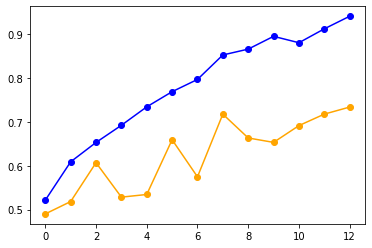

In [19]:
m.plot_training_progress(csv_file_path = m.config_csv_save_name,
                         train_metric = 'categorical_accuracy',
                         validation_metric = 'val_categorical_accuracy')

#### Entropy

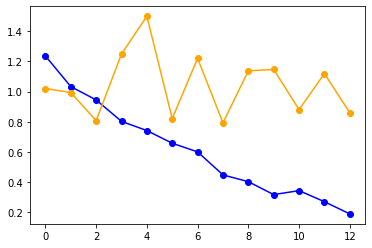

In [20]:
m.plot_training_progress(csv_file_path = m.config_csv_save_name,
                         train_metric = 'loss',
                         validation_metric = 'val_loss')


#### Predict with Model on Test Set

In [21]:
saved_model = keras.models.load_model(m.config_model_save_name)
pred_values = model.predict(test_x)
true_pos = [int(pred_values[i,np.argmax(test_y[i])] >= 0.5) for i in range(test_y.shape[0])]
true_neg = mf.unnest_list_of_lists([[int(y < 0.5) for i, y in enumerate(pred_values[r,:]) if i != np.argmax(test_y[r])] for r in range(test_y.shape[0])])
true_agg = true_pos + true_neg
pd.DataFrame({'accuracy' : [sum(true_agg) / len(true_agg)],
              'true positive rate' : [sum(true_pos) / len(true_pos)],
              'true negative rate' : [sum(true_neg) / len(true_neg)]})

,accuracy,true positive rate,true negative rate
0,0.818548,0.717742,0.868952


#### Look at a Handful of Predictions

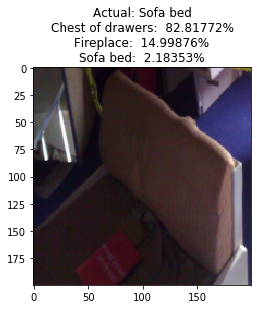

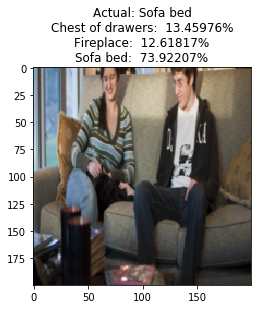

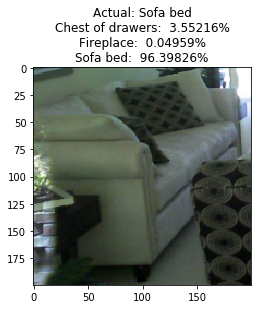

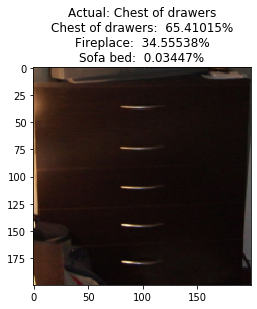

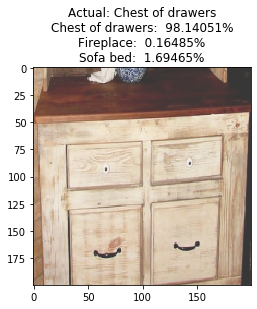

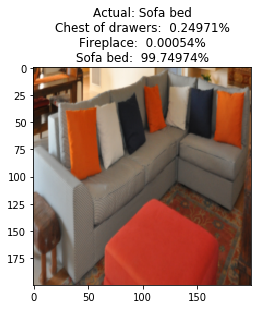

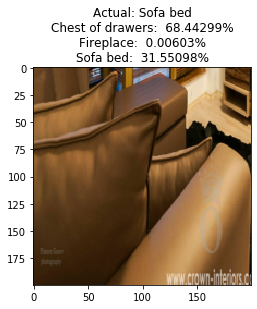

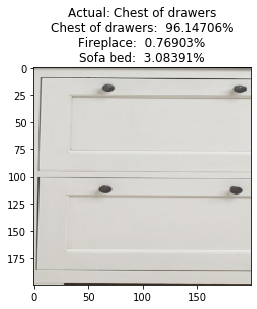

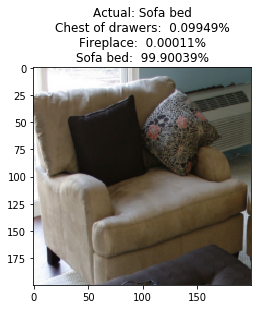

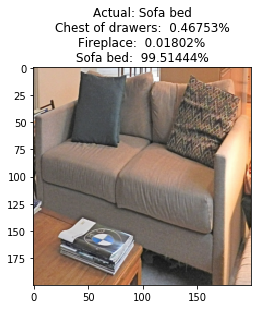

In [22]:
def temp_plot_test_obs(n = 20):
    for i in range(n):
        random_test_obs = random.choice(list(range(test_x.shape[0])))
        class_dict = {0 : 'Chest of drawers', 1 : 'Fireplace', 2 : 'Sofa bed'}
        class_probs = [class_dict.get(i) + ":  " + str(round(x*100,5)) + "%" for i, x in enumerate(pred_values[random_test_obs])]
        actual = class_dict.get(np.argmax(test_y[random_test_obs]))
        plt.imshow(test_x[random_test_obs])
        plt.title("Actual: {a}".format(a = actual) + "\n" + "\n".join(class_probs))
        plt.show()

temp_plot_test_obs(n = 10)